In [ ]:
# Iporting necessary libraries
import os
from random import sample
from torch.utils.data import dataloader
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import statistics
import time
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score,precision_score,recall_score

In [ ]:
# making paths to generalise dataset directories 
ROOT_PATH = os.path.dirname(os.path.abspath("__file__"))
DATA_DIR = os.path.join(ROOT_PATH, 'Dataset_1\\')

In [ ]:
# listing all the classes present in the dataset
folder_array = os.listdir(DATA_DIR)
print(folder_array, type(folder_array))

['A', 'B', 'C', 'D', 'del', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'nothing', 'O', 'P', 'Q', 'R', 'S', 'space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'] <class 'list'>


In [ ]:
# Counting the number of images per class
# Already reduced size from somewhat around 3000 to 450

for i in folder_array:
    # making folder path
    class_folder_path=DATA_DIR+str(i)

    # folder 
    print(class_folder_path)

    # counter per folder
    _, _, files = next(os.walk(class_folder_path))
    file_count = len(files)
    print(file_count)

C:\Users\HP\Downloads\AI_Proj\Dataset_1\A
450
C:\Users\HP\Downloads\AI_Proj\Dataset_1\B
450
C:\Users\HP\Downloads\AI_Proj\Dataset_1\C
450
C:\Users\HP\Downloads\AI_Proj\Dataset_1\D
450
C:\Users\HP\Downloads\AI_Proj\Dataset_1\del
450
C:\Users\HP\Downloads\AI_Proj\Dataset_1\E
450
C:\Users\HP\Downloads\AI_Proj\Dataset_1\F
450
C:\Users\HP\Downloads\AI_Proj\Dataset_1\G
450
C:\Users\HP\Downloads\AI_Proj\Dataset_1\H
450
C:\Users\HP\Downloads\AI_Proj\Dataset_1\I
450
C:\Users\HP\Downloads\AI_Proj\Dataset_1\J
450
C:\Users\HP\Downloads\AI_Proj\Dataset_1\K
450
C:\Users\HP\Downloads\AI_Proj\Dataset_1\L
450
C:\Users\HP\Downloads\AI_Proj\Dataset_1\M
450
C:\Users\HP\Downloads\AI_Proj\Dataset_1\N
450
C:\Users\HP\Downloads\AI_Proj\Dataset_1\nothing
450
C:\Users\HP\Downloads\AI_Proj\Dataset_1\O
450
C:\Users\HP\Downloads\AI_Proj\Dataset_1\P
450
C:\Users\HP\Downloads\AI_Proj\Dataset_1\Q
450
C:\Users\HP\Downloads\AI_Proj\Dataset_1\R
450
C:\Users\HP\Downloads\AI_Proj\Dataset_1\S
450
C:\Users\HP\Downloads\AI_P

In [ ]:
# getting normalization values for the dataset

dataset_1_path = DATA_DIR

def get_dataset_for_normalization_values(data_path):
    dataset_training_transforms = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor()
    ])
    train_dataset = torchvision.datasets.ImageFolder(root=data_path, transform= dataset_training_transforms)
    dataset = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle = False)
    return dataset

dataset_1 = get_dataset_for_normalization_values(dataset_1_path)


In [ ]:
# function to calculate mean and standard deviation of the dataset inorder to feed it for the transformations during preprcoessing.

def get_mean_and_std(loader):
    mean = 0
    std = 0
    total_image_count = 0
    for images, _ in loader:
        image_count_in_a_batch = images.size(0)
        images = images.view(image_count_in_a_batch,images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_image_count += image_count_in_a_batch

    mean /= total_image_count
    std /= total_image_count

    return mean,std

In [ ]:
mean_1, std_1 = get_mean_and_std(dataset_1)

In [ ]:
# loading/preparing the dataset by applying some preprocessing and augmentation techniques.

def load_dataset(path, test_split, val_split, batch_size, input_size, mean_val, std_dev, len_size_flag):

    transform_dict = {'src' : transforms.Compose(
        [transforms.Resize(224),
         transforms.RandomHorizontalFlip(p=.25),
         transforms.RandomRotation(degrees=15),
         transforms.ToTensor(),
         transforms.Normalize(mean = mean_val, std = std_dev)])}
    
    data = datasets.ImageFolder(root = path, transform= transform_dict['src'])
    train_size = int(len(data)*(1-(test_split + val_split)))
    test_size = int(len(data)*test_split) 
    val_size = int(len(data)*val_split)

    print(data)
    print("SPLIT COUNTS", train_size,test_size,val_size)
#     logically the data was not fitting into the total logic of split so had to make the change, becuase of even and odd number of files.
    if len_size_flag:
        val_size=val_size+1
  
    
    train, test, val = torch.utils.data.random_split(data,[train_size, test_size, val_size])
    data_loader_train = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, drop_last=False, num_workers = 0)
    data_loader_test = torch.utils.data.DataLoader(test, batch_size= batch_size, shuffle=True, drop_last=False, num_workers = 0)
    data_loader_val = torch.utils.data.DataLoader(val, batch_size= batch_size, shuffle=True, drop_last=False, num_workers = 0)
  
    return data_loader_train, data_loader_test, data_loader_val

In [ ]:
# splitting the dataset into train, test and validation splits.
training_1, testing_1, validation_1 = load_dataset(path=dataset_1_path, test_split=0.3, val_split=0.1, batch_size=32, input_size=(224,224), mean_val=mean_1, std_dev=std_1, len_size_flag=False)

Dataset ImageFolder
    Number of datapoints: 13050
    Root location: C:\Users\HP\Downloads\AI_Proj\Dataset_1\
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.25)
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=tensor([0.5197, 0.4998, 0.5150]), std=tensor([0.2025, 0.2315, 0.2404]))
           )
SPLIT COUNTS 7830 3915 1305


In [ ]:
# function to train the dataset as well as testing on the validation set.

def train(num_epochs, model, device, train_loader, val_loader, criterion, optimizer, t_loss, t_acc, v_loss, v_acc):

    total_steps = len(train_loader)
    print('Training starts...........')
    for epoch in range(num_epochs):
        epo_loss = []
        epo_acc = []
        epo_val_loss = []
        epo_val_acc = []
        print('')
        print('Epoch {}'.format(epoch+1))
        for i, data in enumerate(train_loader):
            model.train()
            images, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output,labels)
            loss.backward()
            optimizer.step()
            total = labels.size(0)
            _,predicted = torch.max(output.data, 1)
            correct = (predicted == labels).sum().item()
            accuracy = (correct/total)*100


            correct_val = 0
            total_val = 0
            for data in val_loader:
                model.eval()
                with torch.no_grad():
                    images_val, labels_val = data[0].to(device), data[1].to(device)
                    outputs_val = model(images_val)
                    val_loss = criterion(outputs_val, labels_val)
                    _,predicted_val = torch.max(outputs_val.data, 1)
                    total_val += labels_val.size(0)
                    correct_val += (predicted_val == labels_val).sum().item()
                    val_accuracy = (correct_val/total_val)*100

            if (i + 1) % 81 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Training_loss: {:.4f}, Training_accuracy: {:.2f}%, Validation_loss: {:.4f}, Validation Accuracy: {:.2f}%'
                .format(epoch + 1, num_epochs, i + 1, total_steps, loss.item(), accuracy, val_loss.item(), val_accuracy))
                epo_loss.append(loss.item())
                epo_acc.append(accuracy)
                epo_val_loss.append(val_loss.item())
                epo_val_acc.append(val_accuracy)

        t_loss.append(statistics.mean(epo_loss))
        t_acc.append(statistics.mean(epo_acc))
        v_loss.append(statistics.mean(epo_val_loss))
        v_acc.append(statistics.mean(epo_val_acc))

    return model

In [ ]:
# function to test the dataset on the test set.

def test(model, device, test_loader):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0 
        test_loss = 0
        resnet_y_pred = []
        resnet_y_true = [] 
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            test_loss += criterion(outputs, labels).item() 
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            test_loss /= len(test_loader)
            resnet_y_pred.extend(predicted.data.cpu().numpy()) #Save Predictions
            resnet_y_true.extend(labels.data.cpu().numpy()) # Save Truth

        print('Test Accuracy of the model on the {} test images: {} having an average test loss: {:.4f}'
            .format(total, (correct / total) * 100, test_loss))
    
    return resnet_y_pred, resnet_y_true

In [ ]:
# function to make an evaluation metrics i.e. confusion matrix

def make_confusion_matrix(y_pred,y_true):
    classes = ['A', 'B', 'C', 'D', 'del', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'nothing', 'O', 'P', 'Q', 'R', 'S', 'space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
    n_classes = len(classes)
    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) * n_classes, index = [i for i in classes],
                     columns = [i for i in classes])
    plt.figure(figsize = (30,15))
    sns.heatmap(df_cm, annot=True)

# **ShuffleNet**

In [ ]:
# defining the shufflenet model.
shufflenet_model = models.shufflenet_v2_x1_0(pretrained=False)

In [ ]:
# setting the basic hyperparameters like learning rate, optimizer, loss function and number of epochs used for training the model.
lr = 0.001
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(shufflenet_model.parameters(), lr = lr)
num_epochs = 30

In [ ]:
# checking to see if GPU is availabe and hence putting the model on GPU or "cuda", otherwise "cpu".
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
shufflenet_model.to(device) 

Device: cuda:0


ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_

In [ ]:
# defining empty list for training and validation loss and accuracies.
shufflenet_training_loss = []
shufflenet_training_accuracies = []
shufflenet_val_loss = []
shufflenet_val_accuracies = []

In [ ]:
# training the shufflenet model on the given dataset.
start = time.time()
shufflenet_dataset1 = train(num_epochs, shufflenet_model, device, training_1, validation_1, criterion, optimizer,
                        shufflenet_training_loss, shufflenet_training_accuracies, shufflenet_val_loss, shufflenet_val_accuracies)
end = time.time()
time_taken = end-start
print('Time Taken by Shuffle Net:', time_taken)

Training starts...........

Epoch 1
Epoch [1/30], Step [81/245], Training_loss: 3.1504, Training_accuracy: 12.50%, Validation_loss: 3.2950, Validation Accuracy: 9.81%
Epoch [1/30], Step [162/245], Training_loss: 2.8655, Training_accuracy: 18.75%, Validation_loss: 2.7976, Validation Accuracy: 18.01%
Epoch [1/30], Step [243/245], Training_loss: 1.7437, Training_accuracy: 46.88%, Validation_loss: 2.2441, Validation Accuracy: 32.41%

Epoch 2
Epoch [2/30], Step [81/245], Training_loss: 1.6546, Training_accuracy: 50.00%, Validation_loss: 1.9574, Validation Accuracy: 35.79%
Epoch [2/30], Step [162/245], Training_loss: 1.3725, Training_accuracy: 59.38%, Validation_loss: 1.9230, Validation Accuracy: 46.28%
Epoch [2/30], Step [243/245], Training_loss: 0.9704, Training_accuracy: 65.62%, Validation_loss: 1.3871, Validation Accuracy: 55.40%

Epoch 3
Epoch [3/30], Step [81/245], Training_loss: 0.9314, Training_accuracy: 68.75%, Validation_loss: 0.7169, Validation Accuracy: 62.07%
Epoch [3/30], Step 


Epoch 21
Epoch [21/30], Step [81/245], Training_loss: 0.1008, Training_accuracy: 96.88%, Validation_loss: 0.0072, Validation Accuracy: 94.79%
Epoch [21/30], Step [162/245], Training_loss: 0.2142, Training_accuracy: 93.75%, Validation_loss: 0.0241, Validation Accuracy: 97.78%
Epoch [21/30], Step [243/245], Training_loss: 0.0811, Training_accuracy: 96.88%, Validation_loss: 0.0007, Validation Accuracy: 97.85%

Epoch 22
Epoch [22/30], Step [81/245], Training_loss: 0.0078, Training_accuracy: 100.00%, Validation_loss: 0.0618, Validation Accuracy: 98.16%
Epoch [22/30], Step [162/245], Training_loss: 0.0490, Training_accuracy: 96.88%, Validation_loss: 0.0014, Validation Accuracy: 97.70%
Epoch [22/30], Step [243/245], Training_loss: 0.0795, Training_accuracy: 96.88%, Validation_loss: 0.1425, Validation Accuracy: 98.08%

Epoch 23
Epoch [23/30], Step [81/245], Training_loss: 0.0976, Training_accuracy: 93.75%, Validation_loss: 0.0201, Validation Accuracy: 97.62%
Epoch [23/30], Step [162/245], Tra

In [ ]:
# saving the model weights and accuracies for future reference.
torch.save(shufflenet_dataset1, f'shufflenet_dataset1_{lr}.pt')
np.savez(f'shufflenet_dataset1{lr}_training_loss.npz', shufflenet_training_loss)
np.savez(f'shufflenet_dataset1{lr}_training_accuracies.npz', shufflenet_training_accuracies)
np.savez(f'shufflenet_dataset1{lr}_val_loss.npz', shufflenet_val_loss)
np.savez(f'shufflenet_dataset1{lr}_val_accuracies.npz', shufflenet_val_accuracies)

In [ ]:
# testing the dataset on the test set and returning predicted and truth values.
shufflenet_y_pred , shufflenet_y_true = test(shufflenet_dataset1, device, testing_1)

Test Accuracy of the model on the 3915 test images: 98.41634738186463 having an average test loss: 0.0000


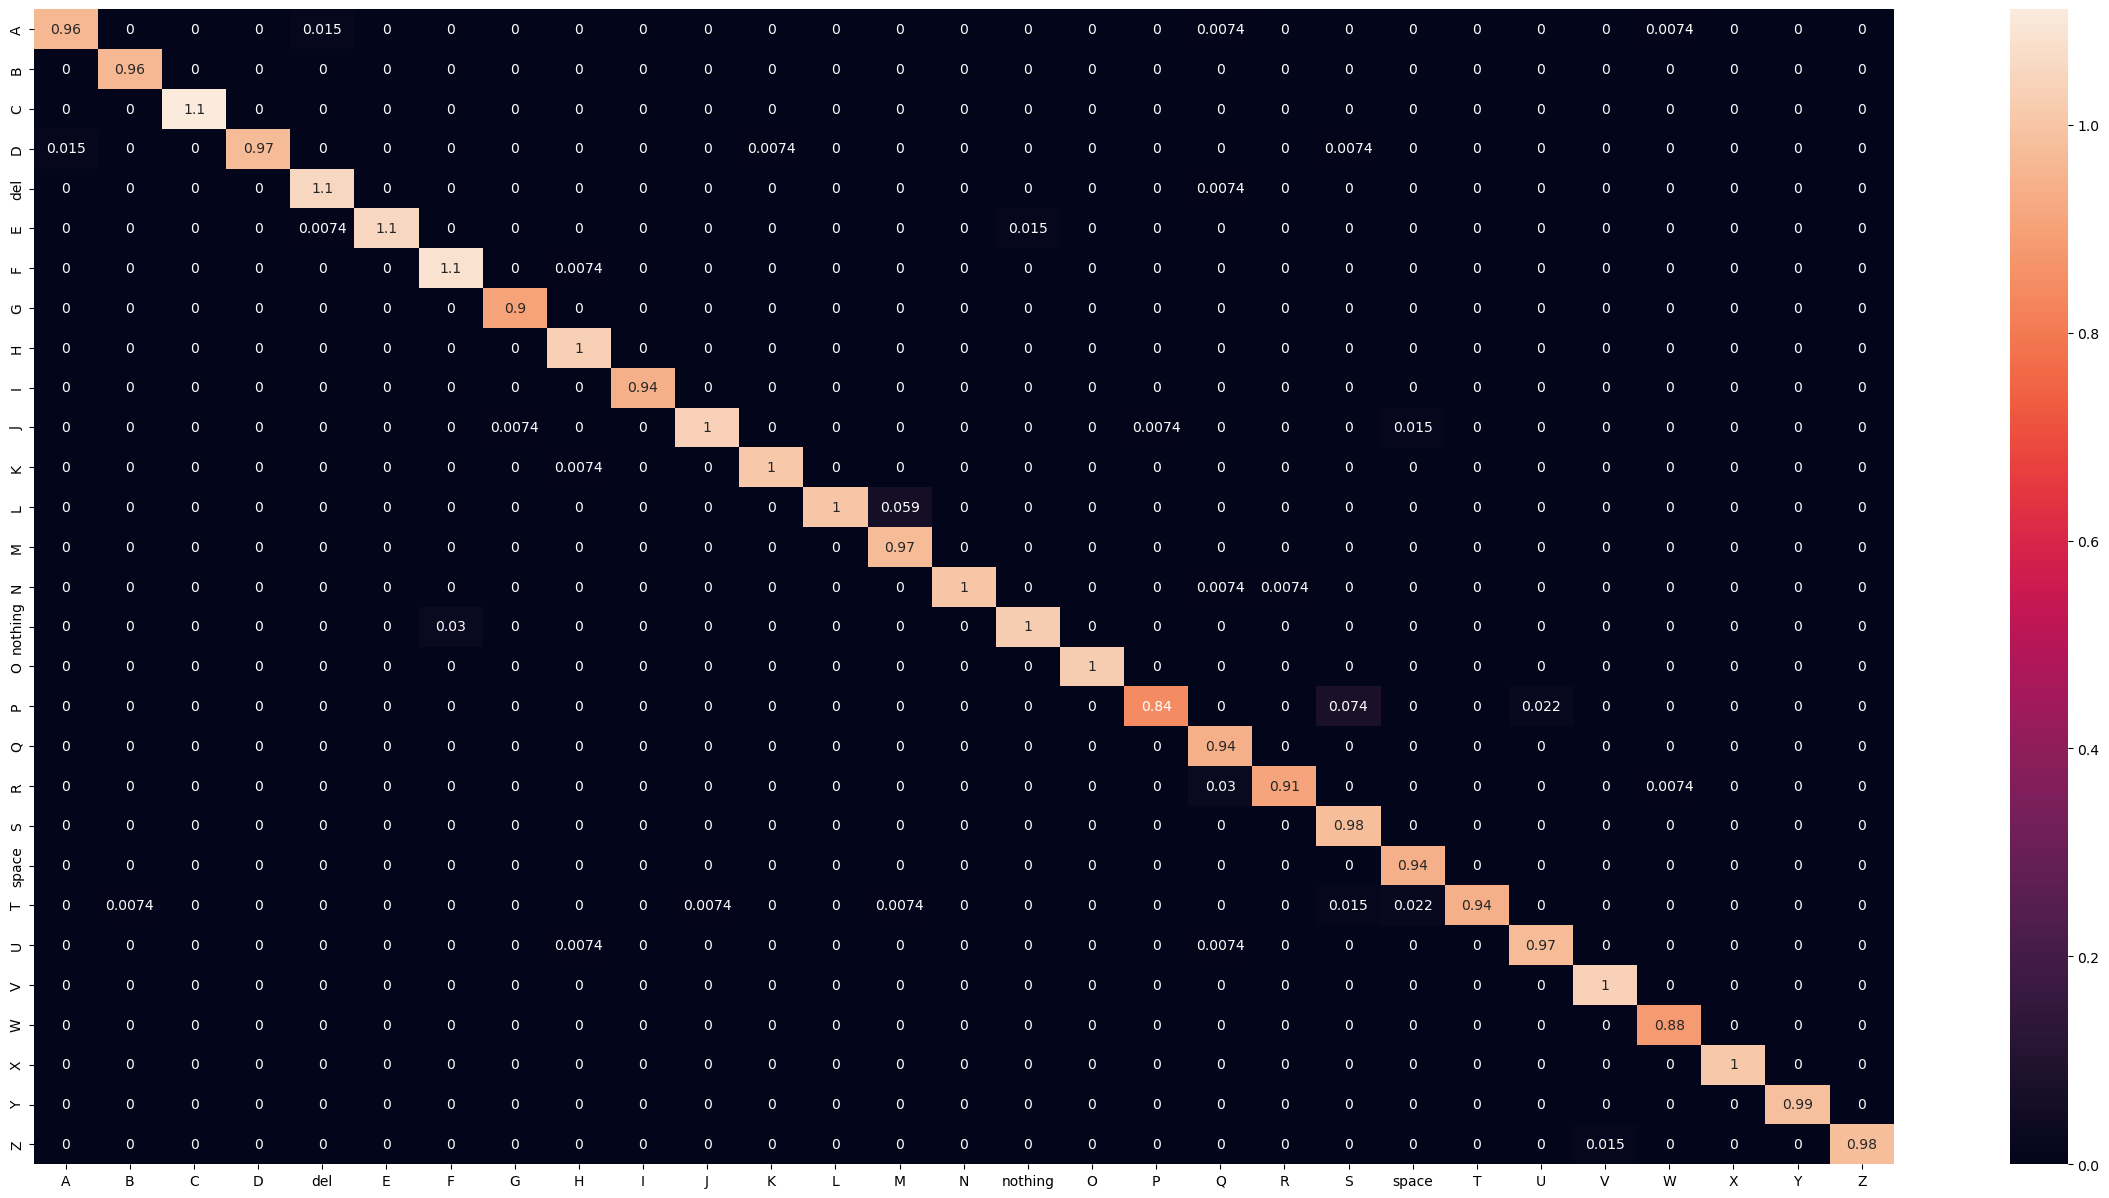

In [ ]:
# calling confusion matrix function to plot the visualisation.
make_confusion_matrix(shufflenet_y_pred , shufflenet_y_true)

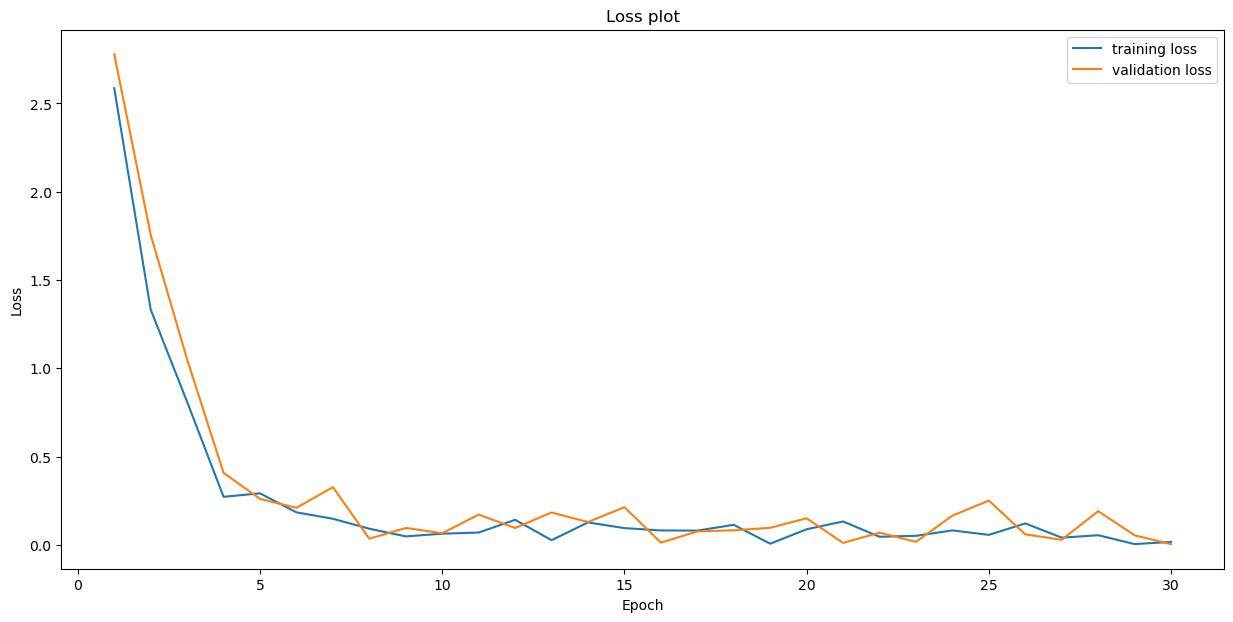

In [ ]:
# plotting both training and validation loss values 

epochs = [i+1 for i in range(num_epochs)]
plt.figure(figsize=(15,7))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss plot')
plt.plot(epochs, shufflenet_training_loss, label = 'training loss')
plt.plot(epochs,shufflenet_val_loss, label = 'validation loss')
plt.legend()

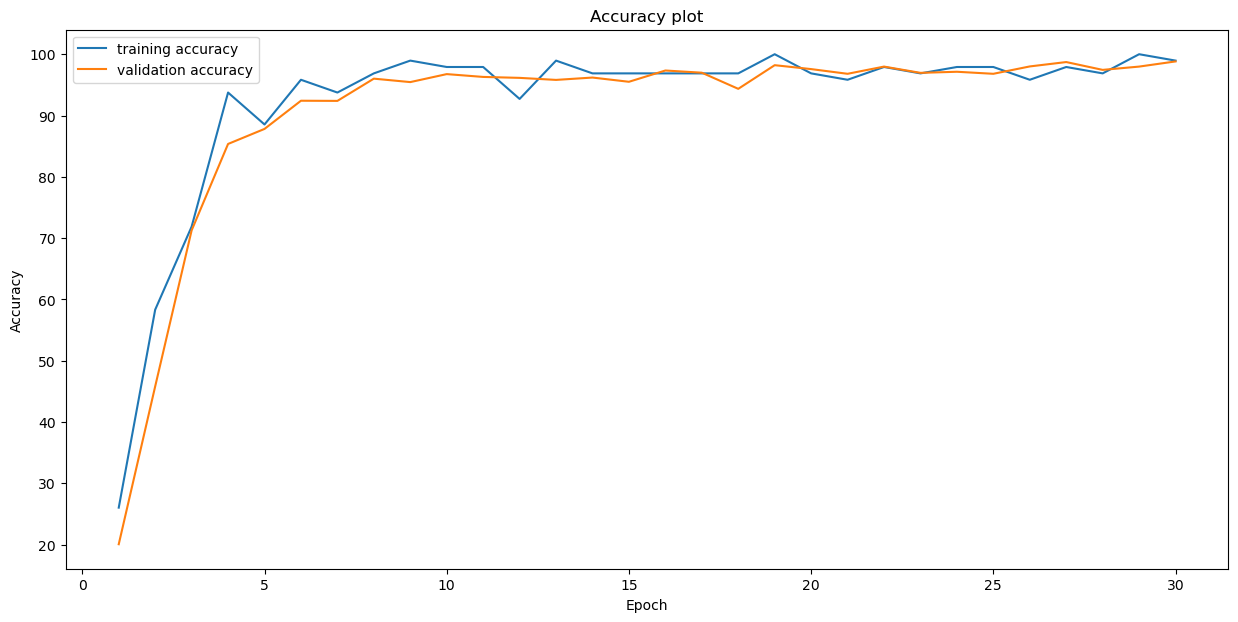

In [ ]:
# plotting both training and validation accuracy values

epochs = [i+1 for i in range(num_epochs)]
plt.figure(figsize=(15,7))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy plot')
plt.plot(epochs, shufflenet_training_accuracies, label = 'training accuracy')
plt.plot(epochs,shufflenet_val_accuracies, label = 'validation accuracy')
plt.legend()

In [ ]:
# calculating different evaluation metrics like F1Score, Precision and Recall.
print("F1 SCORE :-", f1_score(shufflenet_y_true, shufflenet_y_pred, average="macro"))
print("PRECISION :-", precision_score(shufflenet_y_true, shufflenet_y_pred,average="macro"))
print("RECALL :-", recall_score(shufflenet_y_true, shufflenet_y_pred,average="macro"))

F1 SCORE :- 0.9840187293080066
PRECISION :- 0.9845201364108485
RECALL :- 0.9841930569558476


In [ ]:
# Generate Features for TSNE and PCA using model and train dataset

def gen_tsne_features(model, dataloader):
    model.eval()
    targets_list = []
    outputs_list = []

    with torch.no_grad():
        for idx, (inputs, targets) in enumerate(dataloader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            targets_np = targets.data.cpu().numpy()

            outputs = model(inputs)
            outputs_np = outputs.data.cpu().numpy()
            
            targets_list.append(targets_np[:, np.newaxis])
            outputs_list.append(outputs_np)
            
            if ((idx+1) % 10 == 0) or (idx+1 == len(dataloader)):
                print(idx+1, '/', len(dataloader))

    targets = np.concatenate(targets_list, axis=0)
    outputs = np.concatenate(outputs_list, axis=0).astype(np.float64)

    return targets, outputs

In [ ]:
# plot the tsne => train and plot both

def tsne_plot(targets, outputs):
    print('generating t-SNE plot...')
    tsne = TSNE(random_state=0)
    tsne_output = tsne.fit_transform(outputs)

    df = pd.DataFrame(tsne_output, columns=['x', 'y'])
    df['targets'] = targets

    plt.rcParams['figure.figsize'] = 15, 15
    sns.scatterplot(
        x='x', y='y',
        cmap=targets,
        hue='targets',
        palette=sns.color_palette("hls", 36),
        data=df,
        marker='o',
        legend="full",
        alpha=0.5
    )

    plt.xticks([])
    plt.yticks([])
    plt.xlabel('')
    plt.ylabel('')

In [ ]:
targets, outputs = gen_tsne_features(shufflenet_dataset1, training_1)

10 / 245
20 / 245
30 / 245
40 / 245
50 / 245
60 / 245
70 / 245
80 / 245
90 / 245
100 / 245
110 / 245
120 / 245
130 / 245
140 / 245
150 / 245
160 / 245
170 / 245
180 / 245
190 / 245
200 / 245
210 / 245
220 / 245
230 / 245
240 / 245
245 / 245


generating t-SNE plot...


C:\Users\HP\anaconda3\envs\py39\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\HP\anaconda3\envs\py39\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\HP\AppData\Local\Temp\ipykernel_13884\442704285.py:14: UserWarning: The palette list has more values (36) than needed (29), which may not be intended.
  sns.scatterplot(


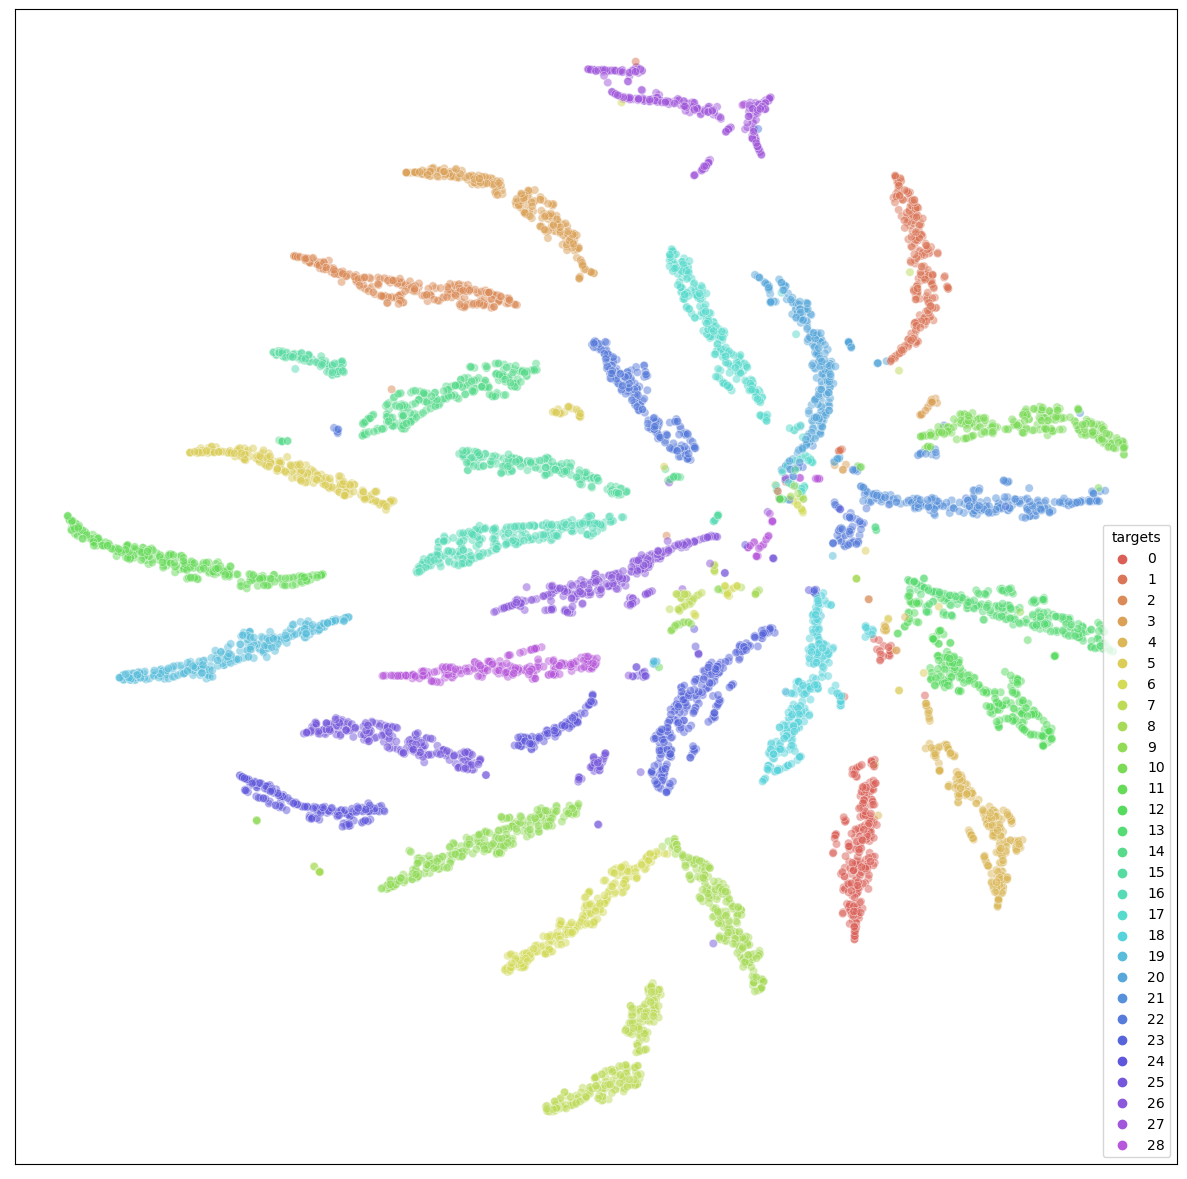

In [ ]:
tsne_plot(targets, outputs)